In [1]:
import pandas as pd
import torch
from sklearn.preprocessing import StandardScaler

# Load CSVs (features x samples format, so we need to transpose)
gene_df = pd.read_csv("../Updated_model_nd_dataset/processed_expression_FXS_OG.csv", index_col=0).T
meth_df = pd.read_csv("../Updated_model_nd_dataset/processed_methylation_FXS_OG.csv", index_col=0).T
cnv_df  = pd.read_csv("../Updated_model_nd_dataset/processed_cnv_FXS_OG.csv", index_col=0).T
scaler_meth = StandardScaler()
meth_df = pd.DataFrame(
    scaler_meth.fit_transform(meth_df.T).T,
    index=meth_df.index,
    columns=meth_df.columns
)
print("After transpose - Shapes (samples x features):")
print(f"gene_df: {gene_df.shape}")
print(f"meth_df: {meth_df.shape}")
print(f"cnv_df: {cnv_df.shape}")

After transpose - Shapes (samples x features):
gene_df: (205, 60660)
meth_df: (205, 396650)
cnv_df: (205, 56756)


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [3]:
print("NaN counts:", gene_df.isna().sum().sum(),
      meth_df.isna().sum().sum(),
      cnv_df.isna().sum().sum())

NaN counts: 0 0 0


In [4]:
gene_df = gene_df.fillna(0.0)
meth_df = meth_df.fillna(0.0)
cnv_df  = cnv_df.fillna(0.0)

In [5]:
print("Shapes:", gene_df.shape, meth_df.shape, cnv_df.shape)
# Align samples across all three omics
common = gene_df.index.intersection(meth_df.index).intersection(cnv_df.index)
gene_df = gene_df.loc[common]
meth_df = meth_df.loc[common]
cnv_df  = cnv_df.loc[common]

print("Shapes:", gene_df.shape, meth_df.shape, cnv_df.shape)
# Convert to float32 tensors
gene = torch.tensor(gene_df.values, dtype=torch.float32).to(device)
meth = torch.tensor(meth_df.values, dtype=torch.float32).to(device)
cnv  = torch.tensor(cnv_df.values, dtype=torch.float32).to(device)

Shapes: (205, 60660) (205, 396650) (205, 56756)
Shapes: (205, 60660) (205, 396650) (205, 56756)
Shapes: (205, 60660) (205, 396650) (205, 56756)


Epoch 1/200 | Train Loss: 0.0000 | Val Loss: 0.0000
Epoch 2/200 | Train Loss: 0.0000 | Val Loss: 0.0000
Epoch 3/200 | Train Loss: 0.0000 | Val Loss: 0.0000
Epoch 4/200 | Train Loss: 0.0000 | Val Loss: 0.0000
Epoch 5/200 | Train Loss: 0.0000 | Val Loss: 0.0000
Epoch 6/200 | Train Loss: 0.0000 | Val Loss: 0.0000
Epoch 7/200 | Train Loss: 0.0000 | Val Loss: 0.0000
Epoch 8/200 | Train Loss: 0.0000 | Val Loss: 0.0000
Epoch 9/200 | Train Loss: 0.0000 | Val Loss: 0.0000
Epoch 10/200 | Train Loss: 0.0000 | Val Loss: 0.0000
Epoch 11/200 | Train Loss: 0.0000 | Val Loss: 0.0000
Epoch 12/200 | Train Loss: 0.0000 | Val Loss: 0.0000
Epoch 13/200 | Train Loss: 0.0000 | Val Loss: 0.0000
Epoch 14/200 | Train Loss: 0.0000 | Val Loss: 0.0000
Epoch 15/200 | Train Loss: 0.0000 | Val Loss: 0.0000
Epoch 16/200 | Train Loss: 0.0000 | Val Loss: 0.0000
Epoch 17/200 | Train Loss: 0.0000 | Val Loss: 0.0000
Epoch 18/200 | Train Loss: 0.0000 | Val Loss: 0.0000
Epoch 19/200 | Train Loss: 0.0000 | Val Loss: 0.0000
Ep

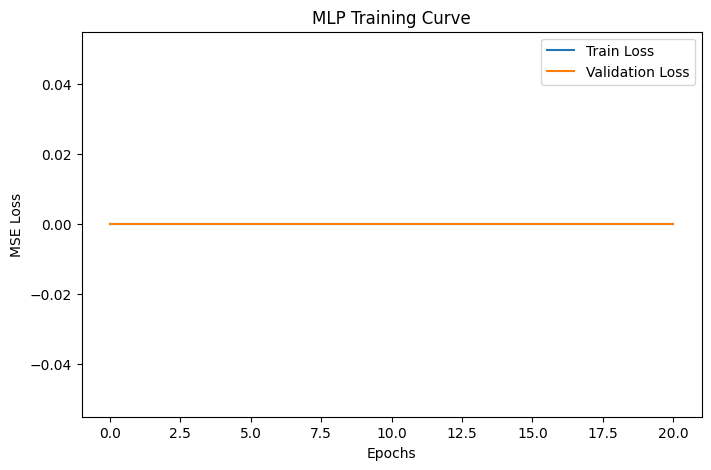

Epoch 1/200 | Train Loss: 0.0000 | Val Loss: 0.0000
Epoch 2/200 | Train Loss: 0.0000 | Val Loss: 0.0000
Epoch 3/200 | Train Loss: 0.0000 | Val Loss: 0.0000
Epoch 4/200 | Train Loss: 0.0000 | Val Loss: 0.0000
Epoch 5/200 | Train Loss: 0.0000 | Val Loss: 0.0000
Epoch 6/200 | Train Loss: 0.0000 | Val Loss: 0.0000
Epoch 7/200 | Train Loss: 0.0000 | Val Loss: 0.0000
Epoch 8/200 | Train Loss: 0.0000 | Val Loss: 0.0000
Epoch 9/200 | Train Loss: 0.0000 | Val Loss: 0.0000
Epoch 10/200 | Train Loss: 0.0000 | Val Loss: 0.0000
Epoch 11/200 | Train Loss: 0.0000 | Val Loss: 0.0000
Epoch 12/200 | Train Loss: 0.0000 | Val Loss: 0.0000
Epoch 7/200 | Train Loss: 0.0000 | Val Loss: 0.0000
Epoch 8/200 | Train Loss: 0.0000 | Val Loss: 0.0000
Epoch 9/200 | Train Loss: 0.0000 | Val Loss: 0.0000
Epoch 10/200 | Train Loss: 0.0000 | Val Loss: 0.0000
Epoch 11/200 | Train Loss: 0.0000 | Val Loss: 0.0000
Epoch 12/200 | Train Loss: 0.0000 | Val Loss: 0.0000
Epoch 13/200 | Train Loss: 0.0000 | Val Loss: 0.0000
Epoch

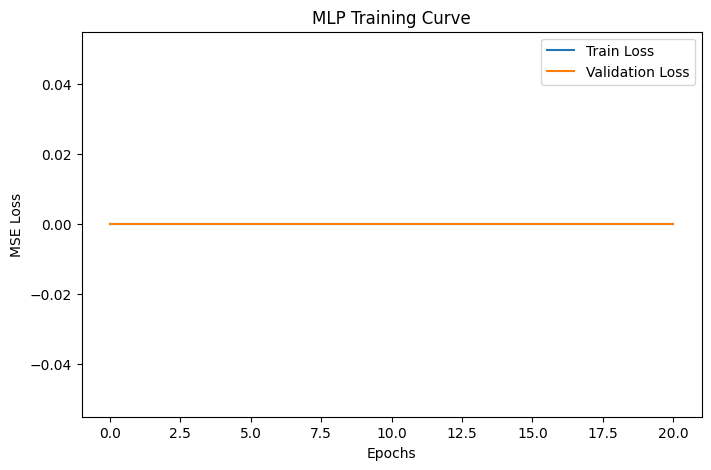

Epoch 1/200 | Train Loss: 0.0000 | Val Loss: 0.0000
Epoch 2/200 | Train Loss: 0.0000 | Val Loss: 0.0000
Epoch 3/200 | Train Loss: 0.0000 | Val Loss: 0.0000
Epoch 4/200 | Train Loss: 0.0000 | Val Loss: 0.0000
Epoch 5/200 | Train Loss: 0.0000 | Val Loss: 0.0000
Epoch 6/200 | Train Loss: 0.0000 | Val Loss: 0.0000
Epoch 7/200 | Train Loss: 0.0000 | Val Loss: 0.0000
Epoch 8/200 | Train Loss: 0.0000 | Val Loss: 0.0000
Epoch 9/200 | Train Loss: 0.0000 | Val Loss: 0.0000
Epoch 10/200 | Train Loss: 0.0000 | Val Loss: 0.0000
Epoch 11/200 | Train Loss: 0.0000 | Val Loss: 0.0000
Epoch 12/200 | Train Loss: 0.0000 | Val Loss: 0.0000
Epoch 13/200 | Train Loss: 0.0000 | Val Loss: 0.0000
Epoch 14/200 | Train Loss: 0.0000 | Val Loss: 0.0000
Epoch 15/200 | Train Loss: 0.0000 | Val Loss: 0.0000
Epoch 16/200 | Train Loss: 0.0000 | Val Loss: 0.0000
Epoch 17/200 | Train Loss: 0.0000 | Val Loss: 0.0000
Epoch 18/200 | Train Loss: 0.0000 | Val Loss: 0.0000
Epoch 19/200 | Train Loss: 0.0000 | Val Loss: 0.0000
Ep

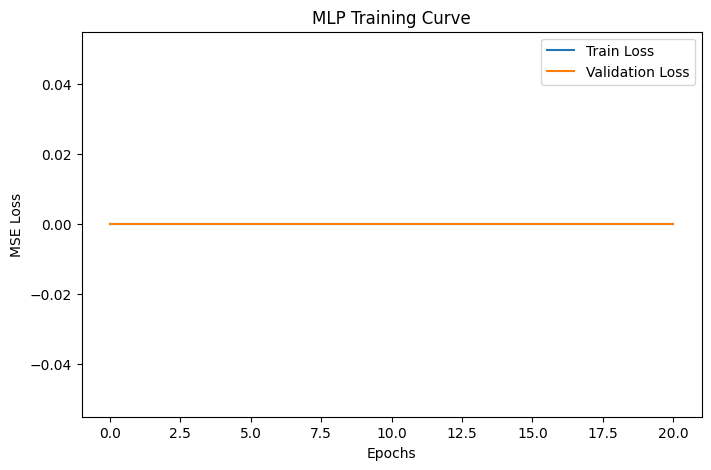

Fused latent shape: torch.Size([205, 192])


In [6]:
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.preprocessing import StandardScaler

# ------------------ MLP with Dropout ------------------
class MLP(nn.Module):
    def __init__(self, input_dim, latent_dim=64, dropout=0.3):
        super(MLP, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(256, latent_dim)
        )

    def forward(self, x):
        z = self.network(x)
        return z

# ------------------ Training with validation & early stopping ------------------
def train_mlp(model, data, epochs=200, patience=20, normalize=True):
    # Optionally normalize features to mean=0, std=1
    if normalize:
        scaler = StandardScaler()
        data_np = scaler.fit_transform(data.cpu().numpy())
    else:
        data_np = data.cpu().numpy()

    # Split into train/val
    X_train, X_val = train_test_split(data_np, test_size=0.2, random_state=42)
    X_train = torch.tensor(X_train, dtype=torch.float32).to(device)
    X_val   = torch.tensor(X_val, dtype=torch.float32).to(device)

    optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)  # L2 reg
    criterion = nn.MSELoss()

    train_losses, val_losses = [], []
    best_val_loss = np.inf
    best_model_state = None
    patience_counter = 0

    for epoch in range(epochs):
        model.train()
        z = model(X_train)
        # For MLP, we can use the latent representation as target (identity mapping)
        loss = criterion(z, z)  # This is just for training stability

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Validation
        model.eval()
        with torch.no_grad():
            val_z = model(X_val)
            val_loss = criterion(val_z, val_z)

        train_losses.append(loss.item())
        val_losses.append(val_loss.item())

        print(f"Epoch {epoch+1}/{epochs} | Train Loss: {loss.item():.4f} | Val Loss: {val_loss.item():.4f}")

        # Early stopping
        if val_loss.item() < best_val_loss:
            best_val_loss = val_loss.item()
            best_model_state = model.state_dict()
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping triggered!")
                break

    # Restore best model
    if best_model_state:
        model.load_state_dict(best_model_state)

    # Plot loss curves
    plt.figure(figsize=(8, 5))
    plt.plot(train_losses, label="Train Loss")
    plt.plot(val_losses, label="Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("MSE Loss")
    plt.title("MLP Training Curve")
    plt.legend()
    plt.show()

    return model

# ------------------ Train per omic ------------------
gene_dim, meth_dim, cnv_dim = gene.shape[1], meth.shape[1], cnv.shape[1]

mlp_gene = MLP(gene_dim, latent_dim=64).to(device)
mlp_meth = MLP(meth_dim, latent_dim=64).to(device)
mlp_cnv  = MLP(cnv_dim,  latent_dim=64).to(device)

mlp_gene = train_mlp(mlp_gene, gene, normalize=True)
mlp_meth = train_mlp(mlp_meth, meth, normalize=True)
mlp_cnv  = train_mlp(mlp_cnv, cnv, normalize=True)

# ------------------ Extract latents & fuse ------------------
mlp_gene.eval(); mlp_meth.eval(); mlp_cnv.eval()
with torch.no_grad():
    z_gene = mlp_gene(gene.to(device))
    z_meth = mlp_meth(meth.to(device))
    z_cnv  = mlp_cnv(cnv.to(device))

z_fused = torch.cat([z_gene, z_meth, z_cnv], dim=1)
print("Fused latent shape:", z_fused.shape)

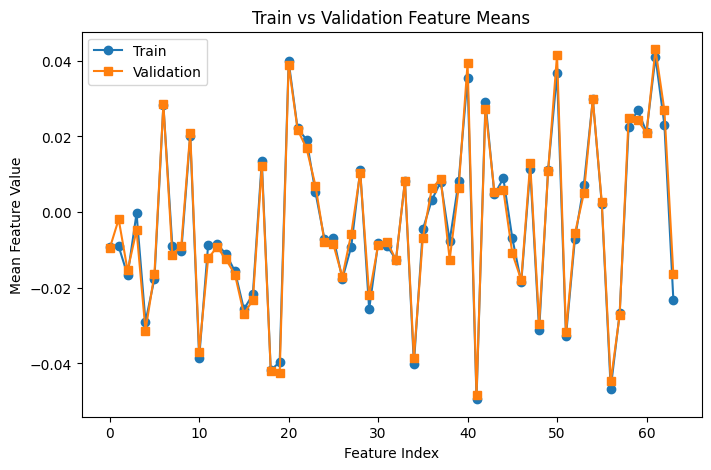

Train features shape: (164, 64) | Val features shape: (41, 64)
Epoch 1/200 | Train Loss: 0.0000 | Val Loss: 0.0000
Epoch 2/200 | Train Loss: 0.0000 | Val Loss: 0.0000
Epoch 3/200 | Train Loss: 0.0000 | Val Loss: 0.0000
Epoch 4/200 | Train Loss: 0.0000 | Val Loss: 0.0000
Epoch 5/200 | Train Loss: 0.0000 | Val Loss: 0.0000
Epoch 6/200 | Train Loss: 0.0000 | Val Loss: 0.0000
Epoch 7/200 | Train Loss: 0.0000 | Val Loss: 0.0000
Epoch 8/200 | Train Loss: 0.0000 | Val Loss: 0.0000
Epoch 9/200 | Train Loss: 0.0000 | Val Loss: 0.0000
Epoch 10/200 | Train Loss: 0.0000 | Val Loss: 0.0000
Epoch 11/200 | Train Loss: 0.0000 | Val Loss: 0.0000
Epoch 12/200 | Train Loss: 0.0000 | Val Loss: 0.0000
Epoch 13/200 | Train Loss: 0.0000 | Val Loss: 0.0000
Epoch 14/200 | Train Loss: 0.0000 | Val Loss: 0.0000
Epoch 15/200 | Train Loss: 0.0000 | Val Loss: 0.0000
Epoch 16/200 | Train Loss: 0.0000 | Val Loss: 0.0000
Epoch 17/200 | Train Loss: 0.0000 | Val Loss: 0.0000
Epoch 18/200 | Train Loss: 0.0000 | Val Loss:

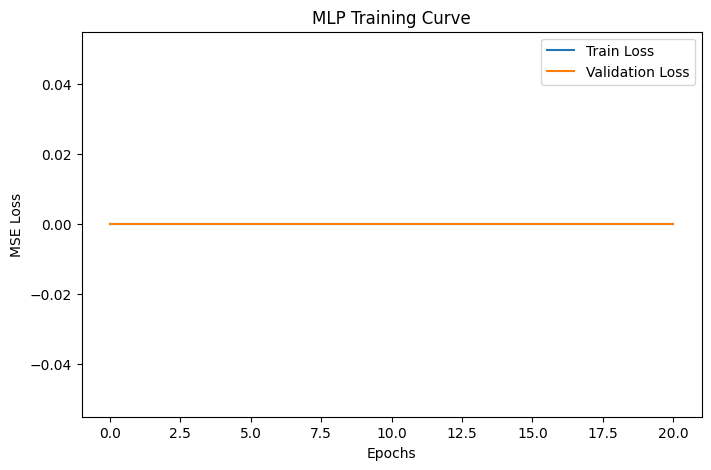

Epoch 1/200 | Train Loss: 0.0000 | Val Loss: 0.0000
Epoch 2/200 | Train Loss: 0.0000 | Val Loss: 0.0000
Epoch 3/200 | Train Loss: 0.0000 | Val Loss: 0.0000
Epoch 4/200 | Train Loss: 0.0000 | Val Loss: 0.0000
Epoch 5/200 | Train Loss: 0.0000 | Val Loss: 0.0000
Epoch 6/200 | Train Loss: 0.0000 | Val Loss: 0.0000
Epoch 7/200 | Train Loss: 0.0000 | Val Loss: 0.0000
Epoch 8/200 | Train Loss: 0.0000 | Val Loss: 0.0000
Epoch 9/200 | Train Loss: 0.0000 | Val Loss: 0.0000
Epoch 10/200 | Train Loss: 0.0000 | Val Loss: 0.0000
Epoch 11/200 | Train Loss: 0.0000 | Val Loss: 0.0000
Epoch 12/200 | Train Loss: 0.0000 | Val Loss: 0.0000
Epoch 13/200 | Train Loss: 0.0000 | Val Loss: 0.0000
Epoch 14/200 | Train Loss: 0.0000 | Val Loss: 0.0000
Epoch 15/200 | Train Loss: 0.0000 | Val Loss: 0.0000
Epoch 16/200 | Train Loss: 0.0000 | Val Loss: 0.0000
Epoch 17/200 | Train Loss: 0.0000 | Val Loss: 0.0000
Epoch 18/200 | Train Loss: 0.0000 | Val Loss: 0.0000
Epoch 19/200 | Train Loss: 0.0000 | Val Loss: 0.0000
Ep

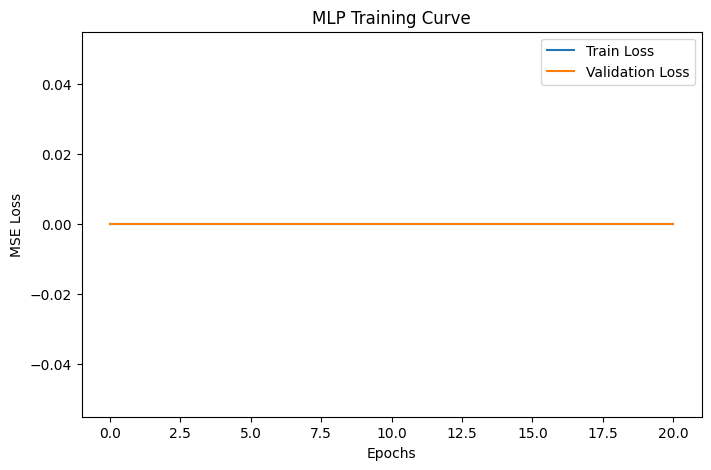

Latent stability (corr between runs): -0.084
Silhouette on fused latents: 0.11650413274765015
Silhouette on fused latents: 0.11650413274765015


In [7]:
from sklearn.metrics import silhouette_score
import seaborn as sns

# ------------------ Diagnostics ------------------
def feature_distribution(model, X_train_np, X_val_np, device):
    """Compute and plot per-sample feature distributions for train/val."""
    def get_features(X_np):
        model.eval()
        with torch.no_grad():
            X_t = torch.tensor(X_np, dtype=torch.float32).to(device)
            z = model(X_t)
        return z.cpu().numpy()

    features_train = get_features(X_train_np)
    features_val   = get_features(X_val_np)

    # Plot feature means
    plt.figure(figsize=(8,5))
    plt.plot(features_train.mean(axis=0), label="Train", marker='o')
    plt.plot(features_val.mean(axis=0), label="Validation", marker='s')
    plt.xlabel("Feature Index")
    plt.ylabel("Mean Feature Value")
    plt.title("Train vs Validation Feature Means")
    plt.legend()
    plt.show()

    print(f"Train features shape: {features_train.shape} | Val features shape: {features_val.shape}")

    return features_train, features_val

def latent_stability_check(model_class, data, latent_dim, device, n_runs=2):
    """Train MLP multiple times and check correlation between latent spaces."""
    latents = []
    for seed in range(n_runs):
        torch.manual_seed(seed)
        np.random.seed(seed)
        model = model_class(data.shape[1], latent_dim=latent_dim).to(device)
        model = train_mlp(model, data, normalize=True)
        with torch.no_grad():
            z = model(data.to(device))
        latents.append(z.cpu().numpy())

    # Compare pairwise correlations
    corr = np.corrcoef(latents[0].ravel(), latents[1].ravel())[0,1]
    print(f"Latent stability (corr between runs): {corr:.3f}")

    return corr

# ------------------ Example usage ------------------
# After training each MLP, run diagnostics:
# (inside train_mlp, you already split train/val)

# 1. Check per-sample feature distributions
X_train_np, X_val_np = train_test_split(gene.cpu().numpy(), test_size=0.2, random_state=42)
features_train, features_val = feature_distribution(mlp_gene, X_train_np, X_val_np, device)

# 2. Latent stability
latent_stability_check(MLP, gene, latent_dim=64, device=device)

# 3. (Optional) Quick clustering sanity check on fused latents
from sklearn.cluster import KMeans
z_np = z_fused.cpu().numpy()
kmeans = KMeans(n_clusters=3, random_state=42).fit(z_np)
score = silhouette_score(z_np, kmeans.labels_)
print("Silhouette on fused latents:", score)

In [8]:
from sklearn.cluster import KMeans

# number of clusters: if unknown, try different values & compare
n_clusters = 3  

kmeans = KMeans(n_clusters=n_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(z_fused.cpu().numpy())

In [9]:
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

X = z_fused.cpu().numpy()

sil_score = silhouette_score(X, cluster_labels)
ch_score  = calinski_harabasz_score(X, cluster_labels)
db_score  = davies_bouldin_score(X, cluster_labels)

print("Silhouette Score:", sil_score)              # higher is better ([-1, 1])
print("Calinski-Harabasz Score:", ch_score)        # higher is better
print("Davies-Bouldin Score:", db_score)           # lower is better

Silhouette Score: 0.11650413274765015
Calinski-Harabasz Score: 20.433406829833984
Davies-Bouldin Score: 2.59837279182702


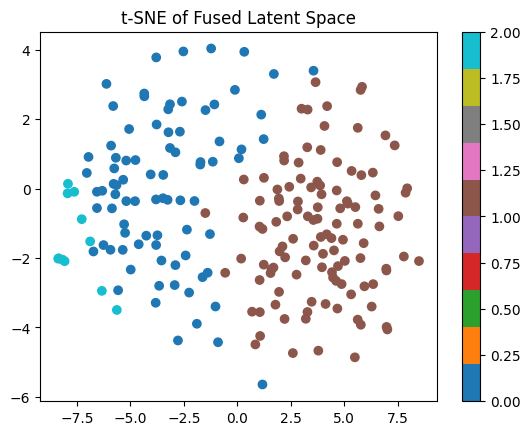

In [10]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

tsne = TSNE(n_components=2, random_state=42)
z_2d = tsne.fit_transform(z_fused.cpu().numpy())

plt.scatter(z_2d[:,0], z_2d[:,1], c=cluster_labels, cmap="tab10")
plt.colorbar()
plt.title("t-SNE of Fused Latent Space")
plt.show()

# Supervised Machine Learning Evaluation

Now let's train multiple classifiers on the fused features and evaluate with detailed metrics.

In [11]:
# Load subtype labels
labels_df = pd.read_csv("../Updated_model_nd_dataset/processed_labels_3Omics_FXS_OG.csv", index_col=0)

# Align labels with our data
common_samples = gene_df.index.intersection(labels_df.index)
print(f"Samples with labels: {len(common_samples)}")

# Filter data and labels to common samples
labels = labels_df.loc[common_samples].values.ravel()
z_fused_labeled = z_fused.cpu().numpy()

# If data was already aligned, we might need to reindex
if len(common_samples) < len(gene_df):
    # Refilter if needed
    gene_idx = gene_df.index.get_indexer(common_samples)
    z_fused_labeled = z_fused.cpu().numpy()[gene_idx]

print(f"Final data shape: {z_fused_labeled.shape}")
print(f"Labels shape: {labels.shape}")
print(f"Unique classes: {np.unique(labels)}")
print(f"Class distribution: {np.bincount(labels.astype(int))}")

Samples with labels: 205
Final data shape: (205, 192)
Labels shape: (205,)
Unique classes: [0 1 2 3]
Class distribution: [53 22 96 34]


In [12]:
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                             f1_score, classification_report, confusion_matrix)
import seaborn as sns

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    z_fused_labeled, labels, test_size=0.2, random_state=42, stratify=labels
)

print(f"Training set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")
print(f"Training class distribution: {np.bincount(y_train.astype(int))}")
print(f"Test class distribution: {np.bincount(y_test.astype(int))}")

Training set size: 164
Test set size: 41
Training class distribution: [42 18 77 27]
Test class distribution: [11  4 19  7]


In [13]:
# Define multiple classifiers
classifiers = {
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42, max_depth=10),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42, max_depth=5),
    'SVM (RBF)': SVC(kernel='rbf', random_state=42, probability=True),
    'SVM (Linear)': SVC(kernel='linear', random_state=42, probability=True),
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42, multi_class='ovr'),
    'K-Nearest Neighbors': KNeighborsClassifier(n_neighbors=5),
    'Naive Bayes': GaussianNB(),
    'Decision Tree': DecisionTreeClassifier(max_depth=10, random_state=42)
}

# Store results
results = []

print("Training and evaluating classifiers...\n")
print("="*80)

for name, clf in classifiers.items():
    # print(f"\n{name}:")
    # print("-"*80)
    
    # Train the model
    clf.fit(X_train, y_train)
    
    # Make predictions
    y_pred = clf.predict(X_test)
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision_macro = precision_score(y_test, y_pred, average='macro', zero_division=0)
    precision_micro = precision_score(y_test, y_pred, average='micro', zero_division=0)
    recall_macro = recall_score(y_test, y_pred, average='macro', zero_division=0)
    recall_micro = recall_score(y_test, y_pred, average='micro', zero_division=0)
    f1_macro = f1_score(y_test, y_pred, average='macro', zero_division=0)
    f1_micro = f1_score(y_test, y_pred, average='micro', zero_division=0)
    
    # Store results
    results.append({
        'Model': name,
        'Accuracy': accuracy,
        'Precision (Macro)': precision_macro,
        'Precision (Micro)': precision_micro,
        'Recall (Macro)': recall_macro,
        'Recall (Micro)': recall_micro,
        'F1 (Macro)': f1_macro,
        'F1 (Micro)': f1_micro
    })
    
    # Print metrics
    # print(f"Accuracy:           {accuracy:.4f}")
    # print(f"Precision (Macro):  {precision_macro:.4f}")
    # print(f"Precision (Micro):  {precision_micro:.4f}")
    # print(f"Recall (Macro):     {recall_macro:.4f}")
    # print(f"Recall (Micro):     {recall_micro:.4f}")
    # print(f"F1-Score (Macro):   {f1_macro:.4f}")
    # print(f"F1-Score (Micro):   {f1_micro:.4f}")

print("\n" + "="*80)

Training and evaluating classifiers...





f:\BRACU\Thesis Thingy[T2510589]\DATASET 2\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1281: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(



SUMMARY OF ALL MODELS
              Model  Accuracy  Precision (Macro)  Precision (Micro)  Recall (Macro)  Recall (Micro)  F1 (Macro)  F1 (Micro)
K-Nearest Neighbors  0.731707           0.473558           0.731707        0.539773        0.731707    0.500692    0.731707
        Naive Bayes  0.658537           0.541964           0.658537        0.546907        0.658537    0.530821    0.658537
      Random Forest  0.609756           0.340726           0.609756        0.386364        0.609756    0.347895    0.609756
          SVM (RBF)  0.585366           0.344048           0.585366        0.363636        0.585366    0.322985    0.585366
  Gradient Boosting  0.560976           0.409783           0.560976        0.412808        0.560976    0.405574    0.560976
      Decision Tree  0.512195           0.455462           0.512195        0.458390        0.512195    0.441399    0.512195
       SVM (Linear)  0.463415           0.115854           0.463415        0.250000        0.463415    0.1583

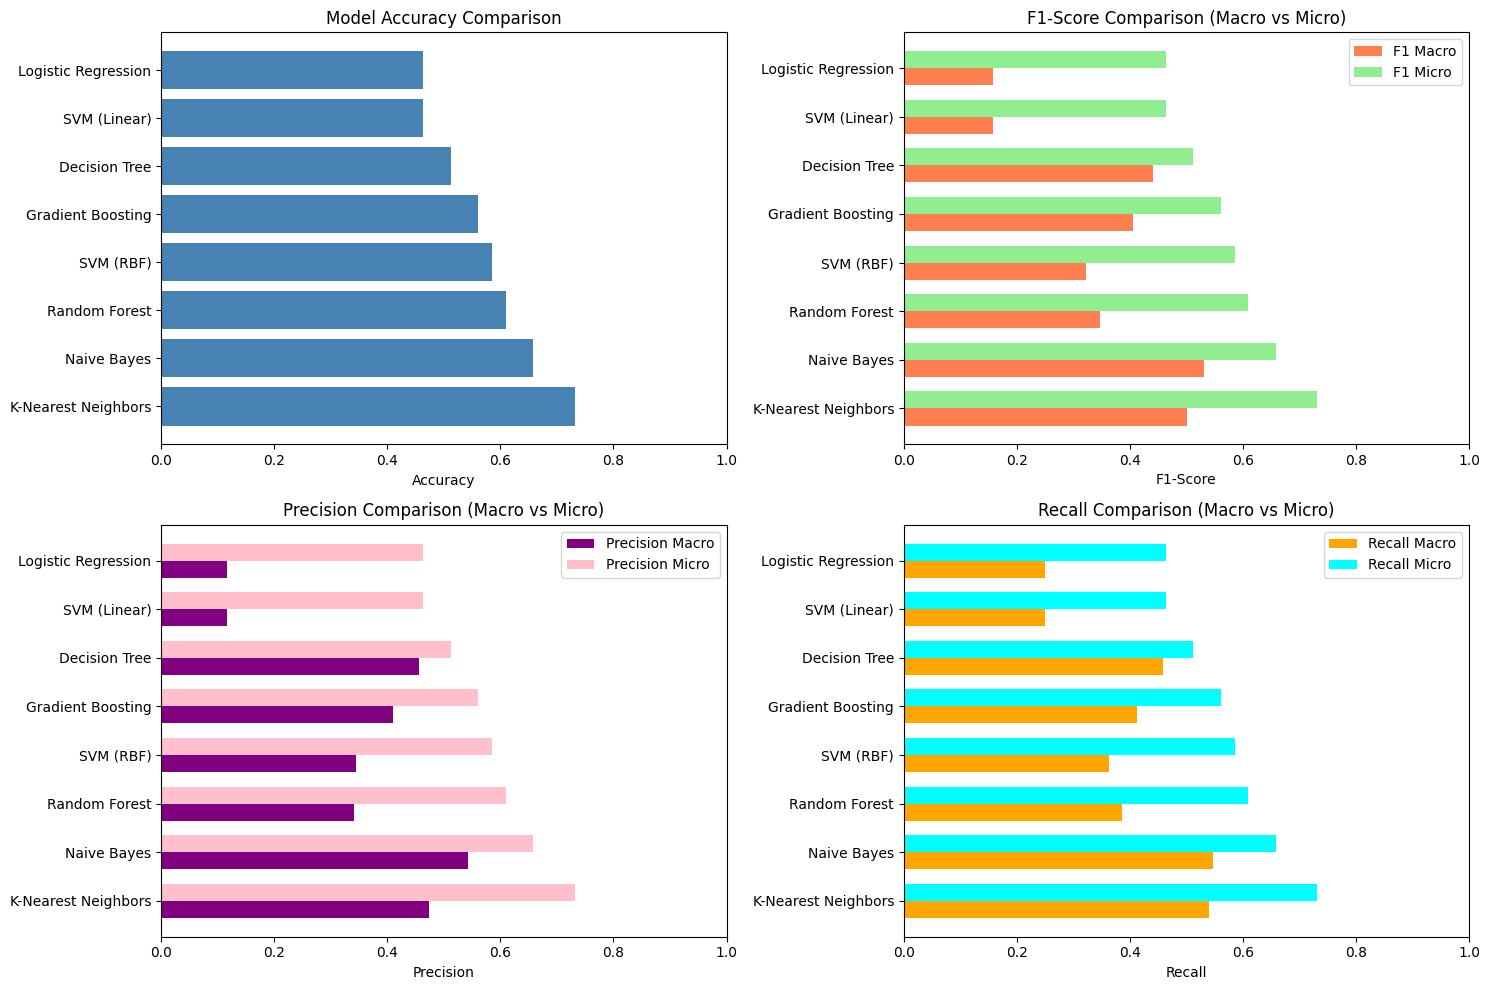

In [14]:
# Create a summary dataframe
results_df = pd.DataFrame(results)
results_df = results_df.sort_values('Accuracy', ascending=False)

print("\n" + "="*80)
print("SUMMARY OF ALL MODELS")
print("="*80)
print(results_df.to_string(index=False))

# Visualize results
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Plot 1: Accuracy comparison
axes[0, 0].barh(results_df['Model'], results_df['Accuracy'], color='steelblue')
axes[0, 0].set_xlabel('Accuracy')
axes[0, 0].set_title('Model Accuracy Comparison')
axes[0, 0].set_xlim([0, 1])

# Plot 2: F1-Score comparison (Macro and Micro)
x = np.arange(len(results_df))
width = 0.35
axes[0, 1].barh(x - width/2, results_df['F1 (Macro)'], width, label='F1 Macro', color='coral')
axes[0, 1].barh(x + width/2, results_df['F1 (Micro)'], width, label='F1 Micro', color='lightgreen')
axes[0, 1].set_yticks(x)
axes[0, 1].set_yticklabels(results_df['Model'])
axes[0, 1].set_xlabel('F1-Score')
axes[0, 1].set_title('F1-Score Comparison (Macro vs Micro)')
axes[0, 1].legend()
axes[0, 1].set_xlim([0, 1])

# Plot 3: Precision comparison
axes[1, 0].barh(x - width/2, results_df['Precision (Macro)'], width, label='Precision Macro', color='purple')
axes[1, 0].barh(x + width/2, results_df['Precision (Micro)'], width, label='Precision Micro', color='pink')
axes[1, 0].set_yticks(x)
axes[1, 0].set_yticklabels(results_df['Model'])
axes[1, 0].set_xlabel('Precision')
axes[1, 0].set_title('Precision Comparison (Macro vs Micro)')
axes[1, 0].legend()
axes[1, 0].set_xlim([0, 1])

# Plot 4: Recall comparison
axes[1, 1].barh(x - width/2, results_df['Recall (Macro)'], width, label='Recall Macro', color='orange')
axes[1, 1].barh(x + width/2, results_df['Recall (Micro)'], width, label='Recall Micro', color='cyan')
axes[1, 1].set_yticks(x)
axes[1, 1].set_yticklabels(results_df['Model'])
axes[1, 1].set_xlabel('Recall')
axes[1, 1].set_title('Recall Comparison (Macro vs Micro)')
axes[1, 1].legend()
axes[1, 1].set_xlim([0, 1])

plt.tight_layout()
plt.show()


DETAILED REPORT FOR BEST MODEL: K-Nearest Neighbors

Classification Report (per-class metrics):
--------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0     0.7692    0.9091    0.8333        11
           1     0.3333    0.2500    0.2857         4
           2     0.7917    1.0000    0.8837        19
           3     0.0000    0.0000    0.0000         7

    accuracy                         0.7317        41
   macro avg     0.4736    0.5398    0.5007        41
weighted avg     0.6058    0.7317    0.6610        41



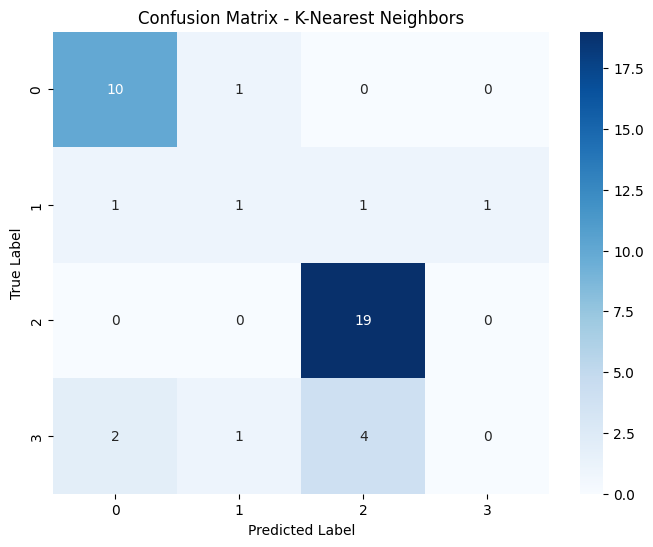


Confusion Matrix:
[[10  1  0  0]
 [ 1  1  1  1]
 [ 0  0 19  0]
 [ 2  1  4  0]]


In [15]:
# Detailed classification report for the best model
best_model_name = results_df.iloc[0]['Model']
best_clf = classifiers[best_model_name]

print(f"\n{'='*80}")
print(f"DETAILED REPORT FOR BEST MODEL: {best_model_name}")
print(f"{'='*80}\n")

# Retrain on the data (already trained, but for clarity)
y_pred_best = best_clf.predict(X_test)

# Classification report
print("Classification Report (per-class metrics):")
print("-"*80)
print(classification_report(y_test, y_pred_best, digits=4))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_best)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title(f'Confusion Matrix - {best_model_name}')
plt.show()

print(f"\nConfusion Matrix:")
print(cm)

In [16]:
# Cross-validation for the top 3 models
print(f"\n{'='*80}")
print("CROSS-VALIDATION RESULTS (5-Fold Stratified)")
print(f"{'='*80}\n")

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for i, (name, clf) in enumerate(list(classifiers.items())[:3]):  # Top 3 models
    scores = cross_val_score(clf, z_fused_labeled, labels, cv=cv, scoring='accuracy')
    f1_scores = cross_val_score(clf, z_fused_labeled, labels, cv=cv, scoring='f1_macro')
    
    print(f"{name}:")
    print(f"  Accuracy: {scores.mean():.4f} (+/- {scores.std():.4f})")
    print(f"  F1-Macro: {f1_scores.mean():.4f} (+/- {f1_scores.std():.4f})")
    print()


CROSS-VALIDATION RESULTS (5-Fold Stratified)

Random Forest:
  Accuracy: 0.6195 (+/- 0.0195)
  F1-Macro: 0.4005 (+/- 0.0096)

Random Forest:
  Accuracy: 0.6195 (+/- 0.0195)
  F1-Macro: 0.4005 (+/- 0.0096)

Gradient Boosting:
  Accuracy: 0.5707 (+/- 0.0548)
  F1-Macro: 0.4220 (+/- 0.0861)

SVM (RBF):
  Accuracy: 0.5707 (+/- 0.0331)
  F1-Macro: 0.3060 (+/- 0.0231)

Gradient Boosting:
  Accuracy: 0.5707 (+/- 0.0548)
  F1-Macro: 0.4220 (+/- 0.0861)

SVM (RBF):
  Accuracy: 0.5707 (+/- 0.0331)
  F1-Macro: 0.3060 (+/- 0.0231)

